In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical

# Ensure no space exists before DATA_PATH
DATA_PATH = r"C:\Users\HP\Desktop\SignSight\model_training_updated\new_video_dataset"

# Updated to match the 10 actions in your folder
actions = np.array(['Drink', 'Eat', 'Good', 'Hello', 'House', 'Man', 'Thank you', 'White', 'Yellow', 'You'])

no_sequences = 50 
sequence_length = 30

In [7]:
label_map = {label: idx for idx, label in enumerate(actions)}

In [9]:
label_map

{'Drink': 0,
 'Eat': 1,
 'Good': 2,
 'Hello': 3,
 'House': 4,
 'Man': 5,
 'Thank you': 6,
 'White': 7,
 'Yellow': 8,
 'You': 9}

In [57]:


# -----------------------------
# LOAD DATA
# -----------------------------
sequences, labels = [], []

for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            # The path format assumes the keypoints were saved in the format:
            # VIDEO_DATA/ActionName/SequenceNumber/FrameNumber.npy
            npy_path = os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy")
            
            if os.path.exists(npy_path):
                res = np.load(npy_path)
                window.append(res)
            else:
                # If you see this error for every file, you need to run Collect Data.ipynb first.
                # If you see it for only one sign, that sign is missing data.
                print(f"File not found: {npy_path}")
                
        # Only append sequences that have the correct length (optional error prevention)
        if len(window) == sequence_length:
            sequences.append(window)
            labels.append(label_map[action])
        else:
            print(f"Skipping sequence {sequence} for action {action}: Found only {len(window)} frames (expected {sequence_length}).")

# Convert to numpy arrays
# Check if sequences were successfully loaded
if not sequences:
    print("\n--- ERROR: No sequences loaded. Check your DATA_PATH and file existence. ---")
else:
    X = np.array(sequences)
    y = np.array(labels)

    print("Data loaded successfully")
    print(f"Total Sequences Loaded: {len(X)}")
    print("X shape:", X.shape)
    print("y shape:", y.shape)



File not found: C:\Users\HP\Desktop\SignSight\model_training_updated\new_video_dataset\You\33\29.npy
Skipping sequence 33 for action You: Found only 29 frames (expected 30).
Data loaded successfully
Total Sequences Loaded: 499
X shape: (499, 30, 258)
y shape: (499,)


In [20]:
from tensorflow.keras.utils import to_categorical

X = np.array(sequences)



In [22]:
y = to_categorical(np.array(labels))

In [24]:
print(f"Total data: {X.shape}")
print(f"Classes: {len(actions)}")

Total data: (499, 30, 258)
Classes: 10


In [26]:
# labels as class indices
labels = np.array(labels)          # 0..len(actions)-1
X = np.array(sequences)

# split first, stratify with indices
X_train, X_test, y_train_idx, y_test_idx = train_test_split(
    X, labels,
    test_size=0.15,
    random_state=42,
    stratify=labels
)

# ippo one‑hot convert pannunga
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train_idx, num_classes=len(actions))
y_test  = to_categorical(y_test_idx,  num_classes=len(actions))


In [28]:
print(X_train.shape)
print(X_test.shape)

(424, 30, 258)
(75, 30, 258)


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [32]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [34]:
model = Sequential()
# 1. Increased units, using 'tanh' activation instead of 'relu'
model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30, 258)))
model.add(Dropout(0.3)) # Added Dropout
model.add(LSTM(256, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=False, activation='tanh'))
model.add(Dropout(0.3))

In [35]:
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(actions), activation='softmax'))

In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['categorical_accuracy']
)

# 2. Setup EarlyStopping
es = EarlyStopping(
    monitor='val_categorical_accuracy', 
    patience=30, 
    restore_best_weights=True
)

print("Model compiled successfully with Adam optimizer and EarlyStopping.")

Model compiled successfully with Adam optimizer and EarlyStopping.


In [44]:
res = [.7, 0.2, 0.1]

In [46]:
model.compile(
    # Decrease the Learning Rate from 1e-3 to 1e-4 for higher accuracy
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
) # <--- Ensure this closing parenthesis is included

In [48]:
#history = model.fit(X_train, y_train, epochs=800, callbacks=[tb_callback])

In [50]:
history = model.fit(
    X_train, y_train,
    # Increase epochs from 250 to 500. It's okay if the model stops early 
    # due to Early Stopping, but this gives it a higher chance to converge.
    epochs=500,
    validation_data=(X_test, y_test),
    callbacks=[tb_callback, es]
)

Epoch 1/500
14/14 [==============================] - 19s 418ms/step - loss: 2.3080 - categorical_accuracy: 0.0896 - val_loss: 2.2926 - val_categorical_accuracy: 0.1333
Epoch 2/500
14/14 [==============================] - 3s 219ms/step - loss: 2.2980 - categorical_accuracy: 0.1179 - val_loss: 2.2870 - val_categorical_accuracy: 0.1467
Epoch 3/500
14/14 [==============================] - 3s 214ms/step - loss: 2.2906 - categorical_accuracy: 0.1179 - val_loss: 2.2677 - val_categorical_accuracy: 0.2133
Epoch 4/500
14/14 [==============================] - 3s 199ms/step - loss: 2.2720 - categorical_accuracy: 0.1132 - val_loss: 2.2533 - val_categorical_accuracy: 0.1600
Epoch 5/500
14/14 [==============================] - 3s 199ms/step - loss: 2.2530 - categorical_accuracy: 0.1627 - val_loss: 2.2358 - val_categorical_accuracy: 0.2267
Epoch 6/500
14/14 [==============================] - 3s 205ms/step - loss: 2.2303 - categorical_accuracy: 0.1604 - val_loss: 2.2152 - val_categorical_accuracy: 0.22

In [53]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test loss and test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 0s 54ms/step - loss: 1.6130 - categorical_accuracy: 0.5733
Test Loss: 1.6130
Test Accuracy: 0.5733


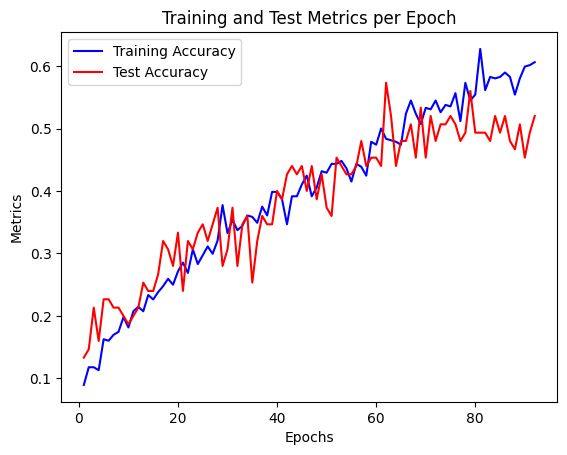

In [55]:
training_accuracy = history.history['categorical_accuracy']
test_accuracy = history.history['val_categorical_accuracy']
test_loss = history.history['val_loss']

epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, test_accuracy, 'r', label='Test Accuracy')
# plt.plot(epochs, test_loss, 'g', label='Test Loss')
plt.title('Training and Test Metrics per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [45]:
# Find the Best Validation Accuracy
best_val_accuracy = np.max(history.history['val_categorical_accuracy'])

# Find the index where the best accuracy occurred
best_epoch_index = np.argmax(history.history['val_categorical_accuracy'])

# Convert the 0-based index to the 1-based Epoch number
best_epoch = best_epoch_index + 1

# Find the training accuracy at that best Epoch
best_train_accuracy = history.history['categorical_accuracy'][best_epoch_index]

# To print the validation accuracy at that best Epoch again, use 
# 'best_val_accuracy'. (This is the best validation accuracy)
best_test_accuracy = best_val_accuracy 


print("\n--- Training Result Summary ---")
print(f"Total number of Epochs run: {len(history.history['val_categorical_accuracy'])}")
print(f"Epoch number where this accuracy was achieved: {best_epoch}")
print("-------------------------------------------------------")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}") # <--- Prints the best value
print(f"Train Accuracy at that Epoch: {best_train_accuracy:.4f}") 
print(f"Test Accuracy at that Epoch: {best_test_accuracy:.4f}") # <--- Corrected line

# Since you used Early Stopping, the Best Weights will be restored from this Epoch.


--- பயிற்சி முடிவு சுருக்கம் (Training Result Summary) ---
மொத்தமாக ஓடிய Epochs எண்ணிக்கை: 131
இந்த துல்லியம் அடைந்த Epoch எண்: 101
-------------------------------------------------------
சிறந்த சோதனை துல்லியம் (Best Test Accuracy): 0.9720
அந்த Epoch-ல் இருந்த பயிற்சி துல்லியம் (Train Accuracy): 0.8860
அந்த Epoch-ல் இருந்த சோதனை துல்லியம் (Test Accuracy): 0.9720


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           198144    
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           394240    
                                                                 
 dropout_1 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               1

In [49]:
# Make Predictions
res = model.predict(X_test)

5/5 [==============================] - 1s 34ms/step


In [50]:
actions[np.argmax(res[0])]

'Mother'

In [51]:
actions[np.argmax(y_test[0])]

'Mother'

In [55]:
# Save Weights
model.save('action.h5')

D:\anaconda3\envs\mp_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
# Evaluation using Confusion Matrix and Accuracy
yhat = model.predict(X_test)

5/5 [==============================] - 0s 36ms/step


In [59]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [61]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [63]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[136,   0],
        [  0,   7]],

       [[136,   0],
        [  0,   7]],

       [[134,   1],
        [  0,   8]],

       [[135,   1],
        [  0,   7]],

       [[135,   0],
        [  0,   8]],

       [[135,   1],
        [  0,   7]],

       [[135,   0],
        [  1,   7]],

       [[135,   0],
        [  0,   8]],

       [[136,   0],
        [  0,   7]],

       [[135,   0],
        [  1,   7]],

       [[135,   0],
        [  0,   8]],

       [[136,   0],
        [  0,   7]],

       [[135,   0],
        [  0,   8]],

       [[135,   1],
        [  0,   7]],

       [[135,   0],
        [  1,   7]],

       [[136,   0],
        [  0,   7]],

       [[136,   0],
        [  0,   7]],

       [[135,   0],
        [  1,   7]],

       [[135,   0],
        [  0,   8]]], dtype=int64)

In [65]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

5/5 [==============================] - 0s 40ms/step - loss: 0.2265 - categorical_accuracy: 0.9720
Test Loss: 0.22648118436336517
Test Accuracy: 0.9720279574394226


In [67]:
accuracy_score(ytrue, yhat)

0.972027972027972